In [1]:
import h5py
import pylab as pl
import numpy as np
import scipy.stats as sp
import matplotlib as mpl
import networkx
import progressbar
import astropy.cosmology as apc
import matplotlib.colors as mpc

In [2]:
def split_unique_id(unique_id):
    """Splits the ids assign to the subhalos by the merger tree code by snap number and subfind number """
    subfind_number = int(unique_id % 1e6)
    snap_number = int((unique_id - subfind_number) / 1e6)
    
    return snap_number, subfind_number

def get_main_branch_unique_ids(subtree, node):
    """Gets the unique ids of the subhalos belonging to the main branch of the selected subhalo (node)"""
    mpb = [node, ]
    i = 0
    while True:
        succesors = list(subtree.successors(node))
        if len(succesors) == 0:
            break
        node = succesors[0] # select only the first succesor (main branch)
        mpb.append(node)
        
    return mpb

In [3]:
pl.rc('font', size = 20)
pl.rc('legend', fontsize = 20)
sim = h5py.File('/data/cielo/simulations/LG1/LG1.hdf5', 'r')
trees = networkx.read_multiline_adjlist('/data/cielo/simulations/LG1/LG1_tree.dat')

In [4]:
Cosmo = apc.FlatLambdaCDM(H0=100, Om0=0.3175)

In [5]:
# a bunch of constants
UnitMass_in_g = 1.989e+43
UnitTime_in_s = 3.08568e+16
UnitVelocity_in_cm_per_s = 100000
UnitDensity_in_cgs = 6.7699e-22
UnitEnergy_in_cgs = 1.989e+53
GAMMA_MINUS1 = 2./3.
PROTONMASS = 1.6726e-24
BOLTZMANN = 1.3806e-16    

HMass = 1.00794
FeMass = 55.845
OMass = 15.9994
NfeNhe_sun = -4.5 # grevesse & saundall 98
NoNfe_sun = 1.33 # same

def tempFromMass(Mass, Abund, IE, ne1):
    XH = Abund[:,6]/Mass
    yHelium = (1. - XH)/(4.*XH)
    mu = (1 + 4.* yHelium)/ (1.+ yHelium + ne1 )
    temp = GAMMA_MINUS1 * IE * mu * 1.6726 / 1.3806 * 1.e-8 # / BOLTZMANN  * PROTONMASS
    temp = temp * 1e10 #   UnitEnergy_in_cgs / UnitMass_in_g;
    return temp

In [6]:
# ok, that doesn't tell me anything, lets see history of this, and then link with other stuff (SFR, los mass, that thing)

def getTemp(gal):
    
    z = []
    t95, t75, t50, t25, t5 = [], [], [], [], []

    uniqueID = int(128*1e6+gal)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))

    
    for m in mtree:
        snap, idd = split_unique_id(int(m))
        
        VelGal = sim['SnapNumber_{}/SubGroups/SubGroupVel'.format(snap)][idd]

        galPos = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]
        
        # other way
        AllP = sim['SnapNumber_{}/PartType0/Coordinates'.format(snap)][()]
        xi, yi, zi = AllP[:,0]-galPos[0], AllP[:,1]-galPos[1], AllP[:,2]-galPos[2]
        rr = np.sqrt(xi**2+yi**2+zi**2)
        inear = np.where(rr<100)[0]
        Loc = sim['SnapNumber_{}/PartType0/SubGroupNumber'.format(snap)][inear]
        ik = np.where(Loc==-1)[0]
        iknear = inear[ik]
        
        IE = sim['SnapNumber_{}/PartType0/InternalEnergy'.format(snap)][iknear]
        Mass = sim['SnapNumber_{}/PartType0/Masses'.format(snap)][iknear]
        Abund = sim['SnapNumber_{}/PartType0/Abundances'.format(snap)][iknear]
        ne1 = sim['SnapNumber_{}/PartType0/ElectronAbundance'.format(snap)][iknear]

        tTemp = tempFromMass(Mass, Abund, IE, ne1)
        
        zs = sim['SnapNumber_{}/Header/Redshift'.format(snap)][()]

        tperC = np.percentile(tTemp, [95, 75, 50, 25, 5])
        
        #ok, i thing i got what i need.
        z.append(zs)
        
        t95.append(tperC[0])
        t75.append(tperC[1])
        t50.append(tperC[2])
        t25.append(tperC[3])
        t5.append(tperC[4])

    z = np.array(z)
    
    t95, t75, t50, t25, t5 = np.array(t95), np.array(t75), np.array(t50), np.array(t25), np.array(t5)
    return z, t95, t75, t50, t25, t5

In [7]:
# z, t95, t75, t50, t25, t5 = getTemp(4338)

In [8]:
# time = Cosmo.lookback_time(z).value

# pl.figure(figsize=(14,14))

# pl.plot(time, np.log10(t95), label='95')
# pl.plot(time, np.log10(t75), label='75')
# pl.plot(time, np.log10(t50), label='50')
# pl.plot(time, np.log10(t25), label='25')
# pl.plot(time, np.log10(t5), label='5')

# pl.legend(loc='best')

# pl.xlabel('time to z=0/$Gyrs$')
# pl.ylabel('log(Temperature/K)')

In [9]:
# z, t95, t75, t50, t25, t5 = getTemp(4474)

In [10]:
# time = Cosmo.lookback_time(z).value

# pl.figure(figsize=(14,14))

# pl.plot(time, np.log10(t95), label='95')
# pl.plot(time, np.log10(t75), label='75')
# pl.plot(time, np.log10(t50), label='50')
# pl.plot(time, np.log10(t25), label='25')
# pl.plot(time, np.log10(t5), label='5')

# pl.legend(loc='best')

# pl.xlabel('time to z=0/$Gyrs$')
# pl.ylabel('log(Temperature/K)')

In [11]:
#ok, now the serialized version of the get particles for each Satellite, lets see.
TdayTotalIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][()] # need this first
I= np.identity(3) # and this

In [12]:
# ok, lets calculate some ram pressures with only hot gas densities, this will be reduced a lot
Msun = 1.988*1e30
kpc = 3.086*1e16


def getSFRs(gal, central):
    
    RPS, z, SFR, snaplist, dist, TPre = [], [], [], [], [], []
    GasMass, StarMass = [], []
    
    Idlist, snapst  = [], []
    
    uniqueID = int(128*1e6+gal)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
    uniqueIDC = int(128*1e6+central)
    streeC = networkx.dfs_tree(trees, str(uniqueIDC))
    mtreeC = get_main_branch_unique_ids(streeC, str(uniqueIDC))
    
    z2, z1 = -1., -1.
    
    ccc = 0
    for m, mC in zip(mtree, mtreeC):
        snap, idd = split_unique_id(int(m))
        snap, iddC = split_unique_id(int(mC))
        
        group = sim['SnapNumber_{}/SubGroups/GroupNumber'.format(snap)][iddC]
        groupPos = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][iddC]
        r200 = sim['SnapNumber_{}/Groups/Group_R_Crit200'.format(snap)][group]

#         OGas = sim['SnapNumber_{}/Groups/PartType0/Offsets'.format(snap)][group].astype('int')
#         Densities = sim['SnapNumber_{}/PartType0/Density'.format(snap)][OGas[0]:OGas[1]]
#         Positions = sim['SnapNumber_{}/PartType0/Coordinates'.format(snap)][OGas[0]:OGas[1]]

#         Loc = sim['SnapNumber_{}/PartType0/SubGroupNumber'.format(snap)][OGas[0]:OGas[1]]

#         i = np.where(Loc==-1)

#         Densities = Densities[i]
#         Positions = Positions[i]
        
#         X, Y, Z = Positions[:,0] - groupPos[0], Positions[:,1] - groupPos[1], Positions[:,2] - groupPos[2]
#         R = np.sqrt(X**2+Y**2+Z**2)/r200

#         rmed1, redges, rbins = sp.binned_statistic(R, Densities*1e10, statistic='median', bins=20, range=(0, 5))
#         rx = 0.5*(redges[:-1]+redges[1:])
        
#         i = np.where(np.isnan(rmed1)==True)
#         rmed1[i] = 0.

#         GroupDens = rmed1*Msun/(kpc**3.)
        
        # ok, lets measure the ram pressure

        VelCen = sim['SnapNumber_{}/SubGroups/SubGroupVel'.format(snap)][iddC]
        VelGal = sim['SnapNumber_{}/SubGroups/SubGroupVel'.format(snap)][idd]

        Vel = np.sqrt(np.sum((VelGal - VelCen)**2.))*1e3 # in m/s

        galPos = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]

        pos = np.sqrt(np.sum((galPos-groupPos)**2))/r200
        
#         DensGal = np.interp(pos, rx, GroupDens)

#         rpsEst = DensGal*Vel**2.
        
        # other way
        AllP = sim['SnapNumber_{}/PartType0/Coordinates'.format(snap)][()]
        xi, yi, zi = AllP[:,0]-galPos[0], AllP[:,1]-galPos[1], AllP[:,2]-galPos[2]
        rr = np.sqrt(xi**2+yi**2+zi**2)
        inear = np.where(rr<100)[0]
        Loc = sim['SnapNumber_{}/PartType0/SubGroupNumber'.format(snap)][inear]
        ik = np.where(Loc==-1)[0]
        iknear = inear[ik]
        #Densities = sim['SnapNumber_{}/PartType0/Density'.format(snap)][iknear]
        
        IE = sim['SnapNumber_{}/PartType0/InternalEnergy'.format(snap)][iknear]
        Mass = sim['SnapNumber_{}/PartType0/Masses'.format(snap)][iknear]
        Abund = sim['SnapNumber_{}/PartType0/Abundances'.format(snap)][iknear]
        ne1 = sim['SnapNumber_{}/PartType0/ElectronAbundance'.format(snap)][iknear]

        tTemp = tempFromMass(Mass, Abund, IE, ne1)
        iT = np.where(tTemp>1e6)[0]
        ikTnear = iknear[iT]
        NoMasses = sim['SnapNumber_{}/PartType0/Masses'.format(snap)][iknear]
        Vol = 3/.4*np.pi*100**3.
        Densities = np.sum(NoMasses)*1e10/Vol
        
        DensGal = Densities*Msun/(kpc**3.)
        
        rpsEst = DensGal*Vel**2.
        
        # and thermal pressure
        
        GasOff = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')
        DMOff = sim['SnapNumber_{}/SubGroups/PartType1/Offsets'.format(snap)][idd].astype('int')
        StarOff = sim['SnapNumber_{}/SubGroups/PartType4/Offsets'.format(snap)][idd].astype('int')
        
        gaspos = sim['SnapNumber_{}/PartType0/Coordinates'.format(snap)][GasOff[0]:GasOff[1]]
        starpos = sim['SnapNumber_{}/PartType4/Coordinates'.format(snap)][StarOff[0]:StarOff[1]]
        DMpos = sim['SnapNumber_{}/PartType1/Coordinates'.format(snap)][DMOff[0]:DMOff[1]]

        nindgas = np.array(range(GasOff[0], GasOff[1]))
#         nindstars = np.array(range(StarOff[0], StarOff[1]))
        nindstars = np.array(range(StarOff[0], StarOff[1]))

        xg, yg, zg = gaspos[:,0]-galPos[0], gaspos[:,1]-galPos[1], gaspos[:,2]-galPos[2]
        xs, ys, zs = starpos[:,0]-galPos[0], starpos[:,1]-galPos[1], starpos[:,2]-galPos[2]

        rg = np.sqrt(xg**2+yg**2+zg**2)
        rs = np.sqrt(xs**2+ys**2+zs**2)

        rad = sim['SnapNumber_{}/SubGroups/OpticalRadius'.format(snap)][idd]
        ig = np.where(rg<=rad)[0]
        iss = np.where(rs<=rad)[0]

        naregas = nindgas[ig]
        narestars = nindstars[iss]

        MassGas = sim['SnapNumber_{}/PartType0/Masses'.format(snap)][naregas]
        MassStars = sim['SnapNumber_{}/PartType4/Masses'.format(snap)][narestars]

        xd, yd, zd = DMpos[:,0]-galPos[0], DMpos[:,1]-galPos[1], DMpos[:,2]-galPos[2]

        rd = np.sqrt(xd**2+yd**2+zd**2)

        r50DM = np.percentile(rd, 50) # I guess
        
        iisist = np.where(rg<r50DM/20.)
        
        pmostCer = nindgas[iisist]
        
        DensMost = np.median(sim['SnapNumber_{}/PartType0/Density'.format(snap)][pmostCer])*1e10
        
        DmMass = sim['SnapNumber_{}/Header/MassTable'.format(snap)][1]
        DMMass = rd.size/2.*DmMass*1e10 # in M_sun
        
        G = 4.3*1e-6 # kpc/M_sun km^2/s^2
        
        Rest = G*DMMass*DensMost/(3*r50DM)
        RestU = Rest*1e3*Msun/(kpc**3)
        
        
        offgal = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')
        
        sfr = sim['SnapNumber_{}/PartType0/StarFormationRate'.format(snap)][offgal[0]:offgal[1]]
        massGas = sim['SnapNumber_{}/PartType0/Masses'.format(snap)][offgal[0]:offgal[1]]
        PosPart = sim['SnapNumber_{}/PartType0/Coordinates'.format(snap)][offgal[0]:offgal[1]]
        OptRad = sim['SnapNumber_{}/SubGroups/OpticalRadius'.format(snap)][idd]
        
        xTc, yTc, zTc = PosPart[:,0]-galPos[0], PosPart[:,1]-galPos[1], PosPart[:,2]-galPos[2]
        distT = np.sqrt(xTc**2.+yTc**2.+zTc**2.)
        icoun = np.where(distT<=OptRad)[0]
        
        TSFR = np.sum(sfr[icoun])
        
        zs = sim['SnapNumber_{}/Header/Redshift'.format(snap)][()]
        
        if pos<2.:
            z2 = zs
        if pos<1.:
            z1 = zs
        
        #ok, i thing i got what i need.
        
#         RPS.append(rpsEst/RestU)
        RPS.append(rpsEst)
        TPre.append(RestU)
        z.append(zs)
        SFR.append(TSFR)
        snaplist.append(snap)
        dist.append(pos)
        GasMass.append(np.sum(MassGas)*1e10)
        StarMass.append(np.sum(MassStars)*1e10)
    
        # and now lost masses
        tempIds = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(snap)][offgal[0]:offgal[1]]
        
        Idlist.extend(list(tempIds))
        snapst.extend([snap]*tempIds.size)
        
    RPS, z, SFR, snaplist, dist = np.array(RPS), np.array(z), np.array(SFR), np.array(snaplist), np.array(dist)
    TPre = np.array(TPre)
    
    GasMass = np.array(GasMass)
    StarMass = np.array(StarMass)
    
    Idlist = np.array(Idlist)
    snapst = np.array(snapst)
    
    Idlist, Idunique = np.unique(Idlist, return_index=True) # remove duplicates
    snapst= snapst[Idunique]
    
#     IndexToday = np.in1d(TdayTotalIDs, Idlist)
#     IndexToday_ = np.where(IndexToday)[0]
    
    TdayOff = sim['SnapNumber_128/SubGroups/PartType0/Offsets'][gal].astype('int')
    
    # lets remove the ones that are not part of the group today.
    TdayIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][TdayOff[0]:TdayOff[1]]

    IndexNot = np.in1d(Idlist, TdayIDs)
    IdNot = Idlist[np.where(IndexNot==False)[0]]

    IndexT = np.in1d(TdayTotalIDs, IdNot)
    IndexT_ = np.where(IndexT)[0]
    
    # and snaps
    SurvIds_ = TdayTotalIDs[IndexT_]
    iidex = np.in1d(Idlist, SurvIds_)
    iidex_ = np.where(iidex)[0]
    snapst_, Idlist_ = snapst[iidex_], Idlist[iidex_]

    is1 = np.argsort(SurvIds_) # the target
    is2 = np.argsort(Idlist_)

    snaporder = np.zeros(IndexT_.size)
    
    snaporder[is1] = snapst_[is2]
    
    GasMasses = sim['SnapNumber_128/PartType0/Masses'][IndexT_]
    
    Gas = []
    for s in snaplist:
        k = np.where(snaporder==s)
        GasT = GasMasses[k]
        Gas.append(np.sum(GasT))
    
    Gas = np.array(Gas)
    
    return RPS, z, SFR, dist, TPre, Gas*1e10, z1, z2, GasMass, StarMass

In [13]:
# ok, lets test this
RPS, z, SFR, dist, RestForce, Gas, z1, z2, gasMass, starMass = getSFRs(4470, 4469)

it = np.where(RPS>0.)
RPS, z, SFR, dist, Gas, RestForce, gasMass, starMass = RPS[it], z[it], SFR[it], dist[it], Gas[it], RestForce[it], gasMass[it], starMass[it]

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


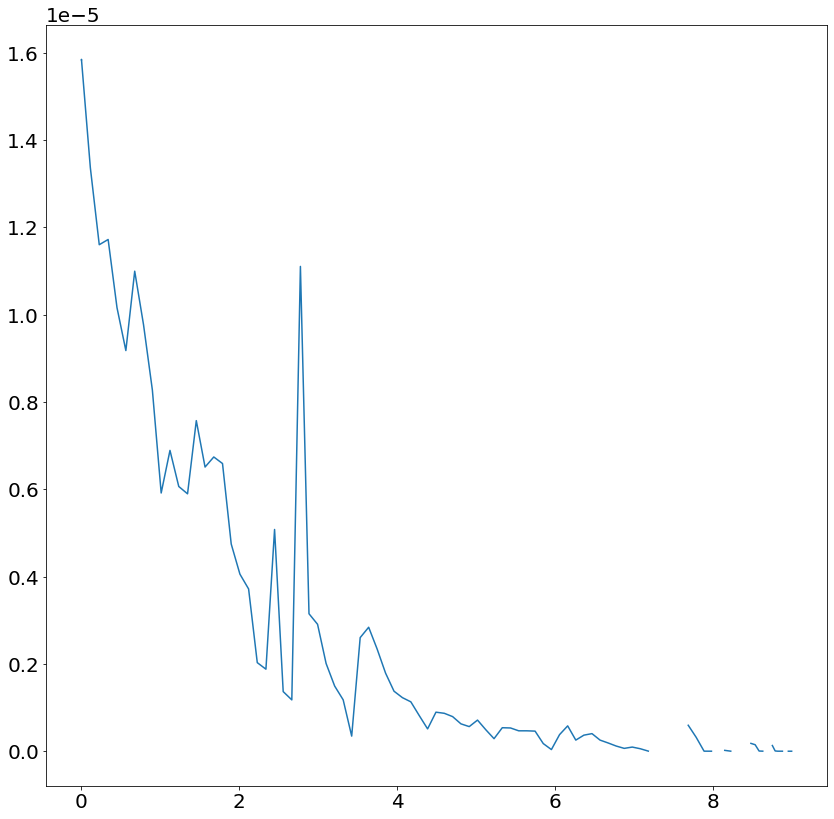

In [14]:
pl.figure(figsize=(14,14))

pl.plot(Cosmo.lookback_time(z).value, RestForce)

In [15]:
tzu = Cosmo.lookback_time(z).value

idd = np.where(dist<=2)
RPS, SFR, gasMass, starMass, Gas, dist, RestForce, tzu = RPS[idd], SFR[idd], gasMass[idd], starMass[idd], Gas[idd], dist[idd], RestForce[idd], tzu[idd]


tz1 = Cosmo.lookback_time(z1).value
tz2 = Cosmo.lookback_time(z2).value

vaper = np.linspace(0, 100, 11)
papels = np.percentile(dist, vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

tmerger = Cosmo.lookback_time(0.38219559019532867).value

0.08557441528498821 0.46170561124483767


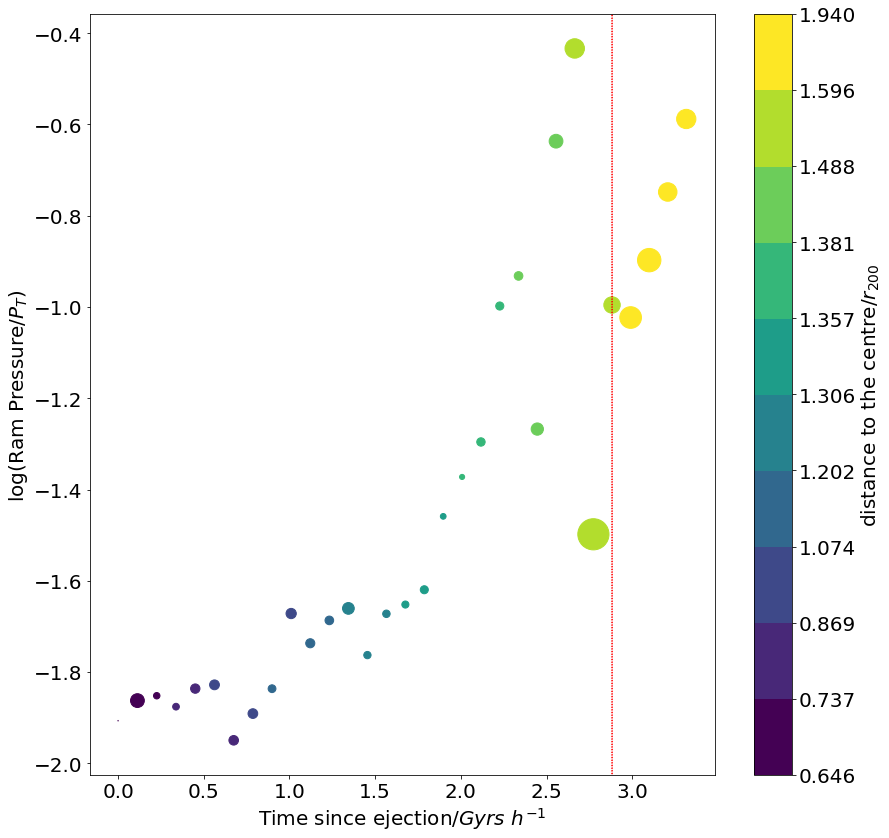

In [16]:
pl.figure(figsize=(14,14))

pl.scatter(tzu, np.log10(RPS/RestForce), s=Gas/5e5, c=dist, norm=norm)

# pl.scatter(tzu, np.log10(RPS), c=dist, norm=norm)

# pl.arrow(tz1, -100., 0., 200, color='black', ls=':')
# pl.arrow(tz2, -100., 0., 200, color='black', ls=':')

pl.arrow(tmerger, -100., 0., 200, color='red', ls=':')

bar = pl.colorbar(label='distance to the centre/$r_{200}$')
bar.set_ticks(papels)

# pl.ylabel('log(Ram Pressure/Pa)')
pl.ylabel('$\log($Ram Pressure$/P_{T})$')
pl.xlabel('Time since ejection/$Gyrs\,\,h^{-1}$')

print(z1, z2)

0.08557441528498821 0.46170561124483767


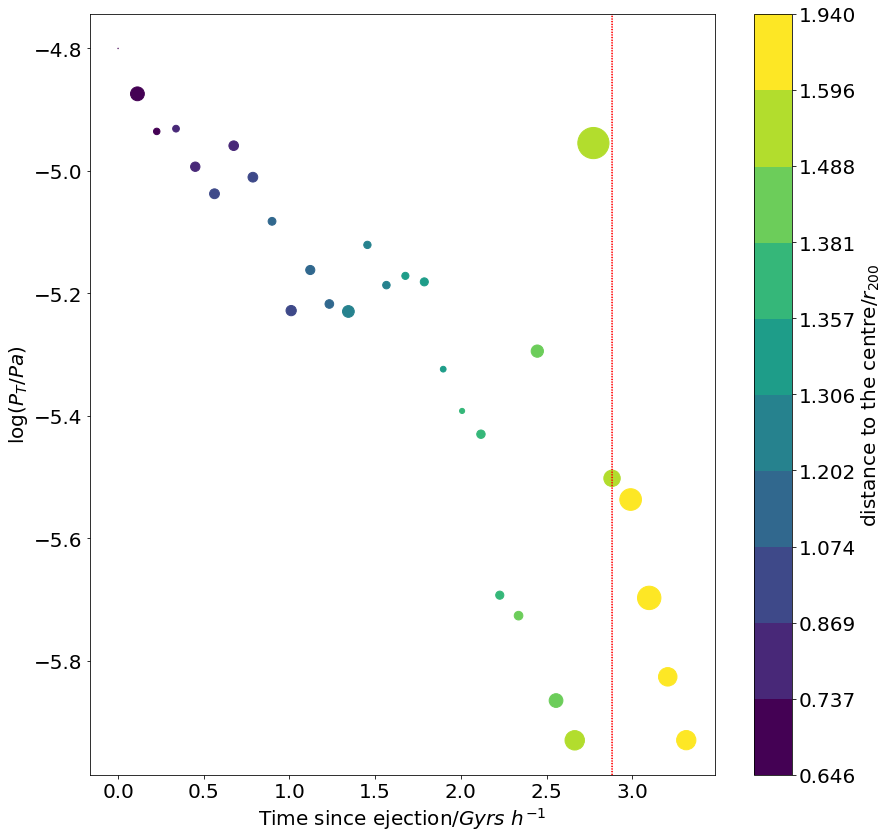

In [17]:
pl.figure(figsize=(14,14))

pl.scatter(tzu, np.log10(RestForce), s=Gas/5e5, c=dist, norm=norm)

# pl.scatter(tzu, np.log10(RPS), c=dist, norm=norm)

# pl.arrow(tz1, -100., 0., 200, color='black', ls=':')
# pl.arrow(tz2, -100., 0., 200, color='black', ls=':')

pl.arrow(tmerger, -100., 0., 200, color='red', ls=':')

bar = pl.colorbar(label='distance to the centre/$r_{200}$')
bar.set_ticks(papels)

# pl.ylabel('log(Ram Pressure/Pa)')
pl.ylabel('$\log(P_{T}/Pa)$')
pl.xlabel('Time since ejection/$Gyrs\,\,h^{-1}$')

print(z1, z2)

In [18]:
# pl.figure(figsize=(14,14))



# lRPS, lSFR = np.log10(RPS/RestForce), np.log10(SFR)
# pl.scatter(lRPS, lSFR, s=Gas/5e5, c=dist, norm=norm)

# inan = np.where((np.isnan(lRPS)==False) & (np.isnan(lSFR)==False) &(np.isinf(lRPS)==False) & (np.isinf(lSFR)==False))

# print(sp.pearsonr(lRPS[inan], lSFR[inan]))

# bar = pl.colorbar(label='distance to the centre/$r_{200}$')
# bar.set_ticks(papels)

# pl.ylabel('$\log($SFR$/(M_{\odot}\,\,yr^{-1}))$')
# pl.xlabel('log(Ram Pressure/$P_T$)')

In [19]:
# pl.figure(figsize=(14,14))

# lsSFR = np.log10(SFR/starMass)
# pl.scatter(lRPS, lsSFR, s=Gas/5e5, c=dist, norm=norm)

# inan = np.where((np.isnan(lRPS)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lRPS)==False) & (np.isinf(lsSFR)==False))

# print(sp.pearsonr(lRPS[inan], lsSFR[inan]))


# bar = pl.colorbar(label='distance to the centre/$r_{200}$')
# bar.set_ticks(papels)

# pl.ylabel('$\log($sSFR$/yr^{-1})$')
# pl.xlabel('log(Ram Pressure/$P_T$)')

In [20]:
# ok, lets test this
RPS, z, SFR, dist, RestForce, Gas, z1, z2, gasMass, starMass = getSFRs(4471, 4469)

it = np.where(RPS>0.)
RPS, z, SFR, dist, Gas, RestForce, gasMass, starMass = RPS[it], z[it], SFR[it], dist[it], Gas[it], RestForce[it], gasMass[it], starMass[it]

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


In [21]:
tzu = Cosmo.lookback_time(z).value

idd = np.where(dist<=2)
RPS, SFR, gasMass, starMass, Gas, dist, RestForce, tzu = RPS[idd], SFR[idd], gasMass[idd], starMass[idd], Gas[idd], dist[idd], RestForce[idd], tzu[idd]

tz1 = Cosmo.lookback_time(z1).value
tz2 = Cosmo.lookback_time(z2).value

vaper = np.linspace(0, 100, 11)
papels = np.percentile(dist, vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)


0.420987180617459 0.4828424047552191


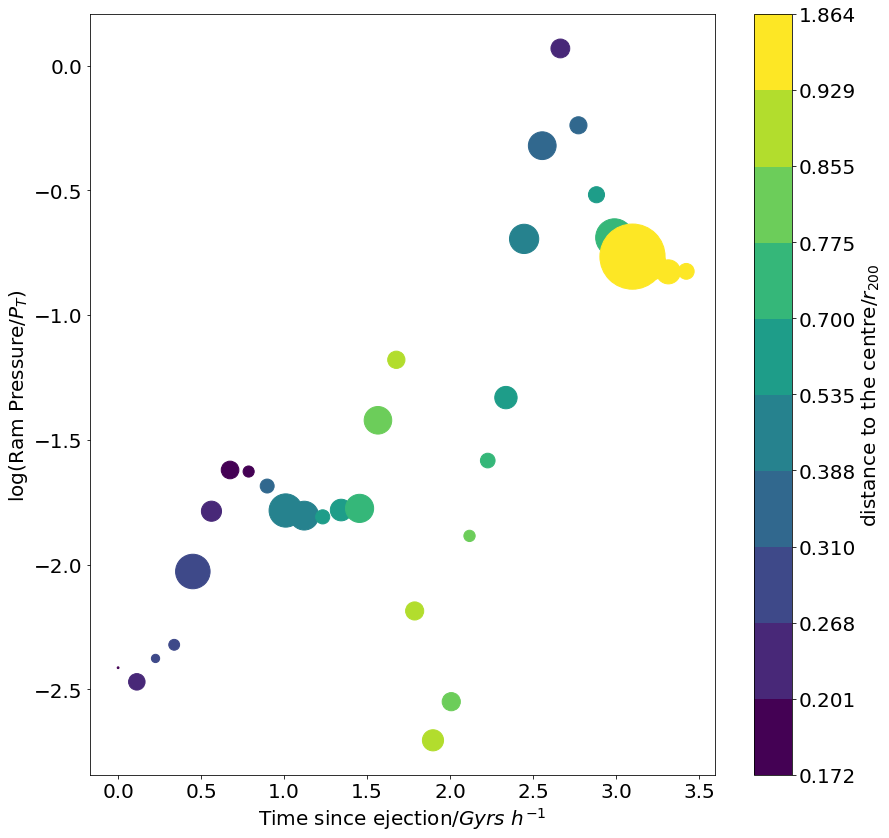

In [22]:
pl.figure(figsize=(14,14))

pl.scatter(tzu, np.log10(RPS/RestForce), s=Gas/5e5, c=dist, norm=norm)

# pl.scatter(tzu, np.log10(RPS), c=dist, norm=norm)

# pl.arrow(tz1, -100., 0., 200, color='black', ls=':')
# pl.arrow(tz2, -100., 0., 200, color='black', ls=':')

bar = pl.colorbar(label='distance to the centre/$r_{200}$')
bar.set_ticks(papels)

# pl.ylabel('log(Ram Pressure/Pa)')
pl.ylabel('$\log($Ram Pressure$/P_{T})$')
pl.xlabel('Time since ejection/$Gyrs\,\,h^{-1}$')

print(z1, z2)

0.420987180617459 0.4828424047552191


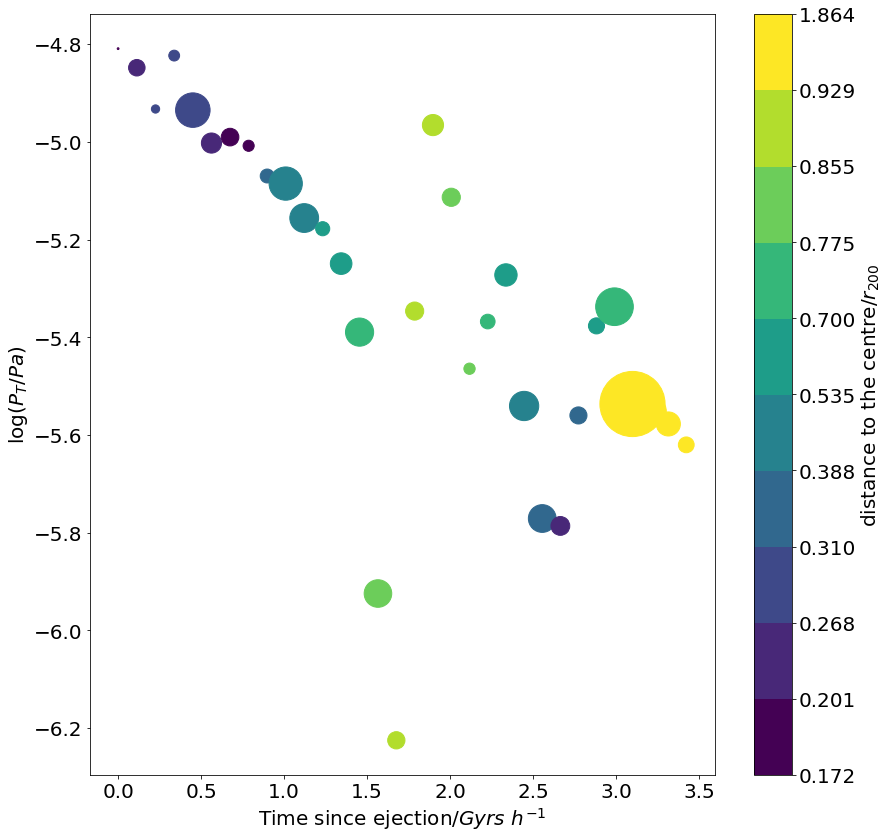

In [23]:
pl.figure(figsize=(14,14))

pl.scatter(tzu, np.log10(RestForce), s=Gas/5e5, c=dist, norm=norm)

# pl.scatter(tzu, np.log10(RPS), c=dist, norm=norm)

# pl.arrow(tz1, -100., 0., 200, color='black', ls=':')
# pl.arrow(tz2, -100., 0., 200, color='black', ls=':')

# pl.arrow(tmerger, -100., 0., 200, color='red', ls=':')

bar = pl.colorbar(label='distance to the centre/$r_{200}$')
bar.set_ticks(papels)

# pl.ylabel('log(Ram Pressure/Pa)')
pl.ylabel('$\log(P_{T}/Pa)$')
pl.xlabel('Time since ejection/$Gyrs\,\,h^{-1}$')

print(z1, z2)

In [24]:
# pl.figure(figsize=(14,14))

# idd = np.where(dist<=3)
# RPS, SFR, gasMass, starMass, Gas, dist, RestForce = RPS[idd], SFR[idd], gasMass[idd], starMass[idd], Gas[idd], dist[idd], RestForce[idd]

# lRPS, lSFR = np.log10(RPS/RestForce), np.log10(SFR)
# pl.scatter(lRPS, lSFR, s=Gas/5e5, c=dist, norm=norm)

# inan = np.where((np.isnan(lRPS)==False) & (np.isnan(lSFR)==False) &(np.isinf(lRPS)==False) & (np.isinf(lSFR)==False))

# print(sp.pearsonr(lRPS[inan], lSFR[inan]))

# bar = pl.colorbar(label='distance to the centre/$r_{200}$')
# bar.set_ticks(papels)

# pl.ylabel('$\log($SFR$/(M_{\odot}\,\,yr^{-1}))$')
# pl.xlabel('log(Ram Pressure/$P_T$)')

In [25]:
# pl.figure(figsize=(14,14))

# lsSFR = np.log10(SFR/starMass)
# pl.scatter(lRPS, lsSFR, s=Gas/5e5, c=dist, norm=norm)

# inan = np.where((np.isnan(lRPS)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lRPS)==False) & (np.isinf(lsSFR)==False))

# print(sp.pearsonr(lRPS[inan], lsSFR[inan]))


# bar = pl.colorbar(label='distance to the centre/$r_{200}$')
# bar.set_ticks(papels)

# pl.ylabel('$\log($sSFR$/yr^{-1})$')
# pl.xlabel('log(Ram Pressure/$P_T$)')

In [26]:
RPS, z, SFR, dist, RestForce, Gas, z1, z2, gasMass, starMass = getSFRs(4473, 4469)

it = np.where(RPS>0.)
RPS, z, SFR, dist, Gas, RestForce, gasMass, starMass = RPS[it], z[it], SFR[it], dist[it], Gas[it], RestForce[it], gasMass[it], starMass[it]

In [27]:
tzu = Cosmo.lookback_time(z).value

idd = np.where(dist<=2)
RPS, SFR, gasMass, starMass, Gas, dist, RestForce, tzu = RPS[idd], SFR[idd], gasMass[idd], starMass[idd], Gas[idd], dist[idd], RestForce[idd], tzu[idd]



tz1 = Cosmo.lookback_time(z1).value
tz2 = Cosmo.lookback_time(z2).value

vaper = np.linspace(0, 100, 11)
papels = np.percentile(dist, vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)


0.1254867544903131 0.2926531855399035


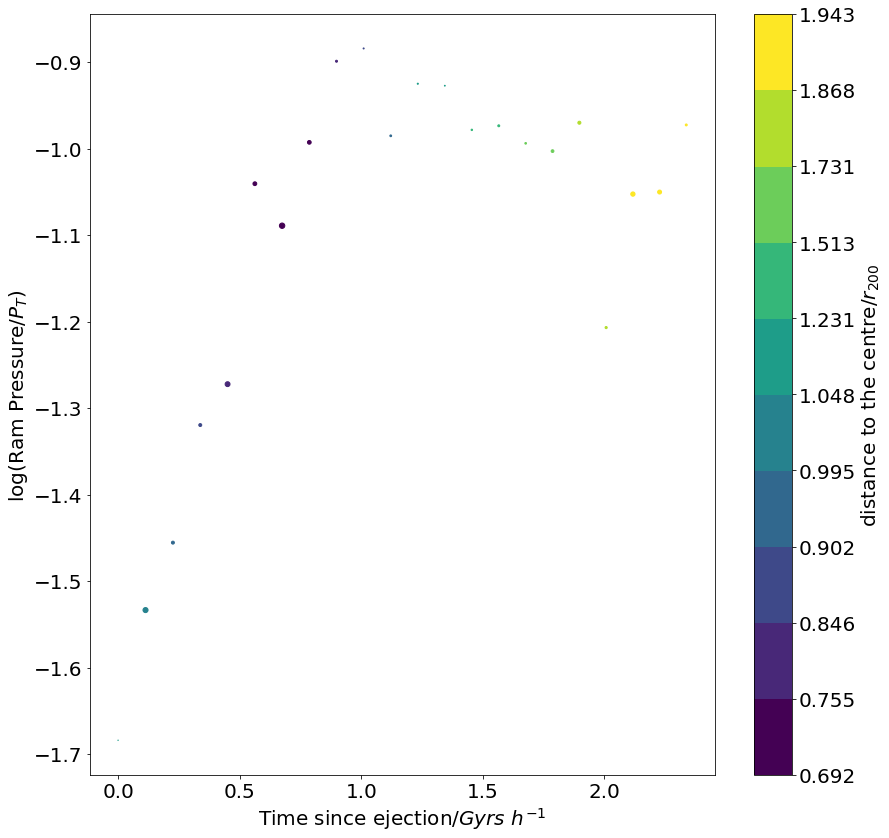

In [28]:
pl.figure(figsize=(14,14))

pl.scatter(tzu, np.log10(RPS/RestForce), s=Gas/5e5, c=dist, norm=norm)

# pl.scatter(tzu, np.log10(RPS), c=dist, norm=norm)

# pl.arrow(tz1, -100., 0., 200, color='black', ls=':')
# pl.arrow(tz2, -100., 0., 200, color='black', ls=':')

bar = pl.colorbar(label='distance to the centre/$r_{200}$')
bar.set_ticks(papels)

# pl.ylabel('log(Ram Pressure/Pa)')
pl.ylabel('$\log($Ram Pressure$/P_T)$')
pl.xlabel('Time since ejection/$Gyrs\,\,h^{-1}$')

print(z1, z2)

0.1254867544903131 0.2926531855399035


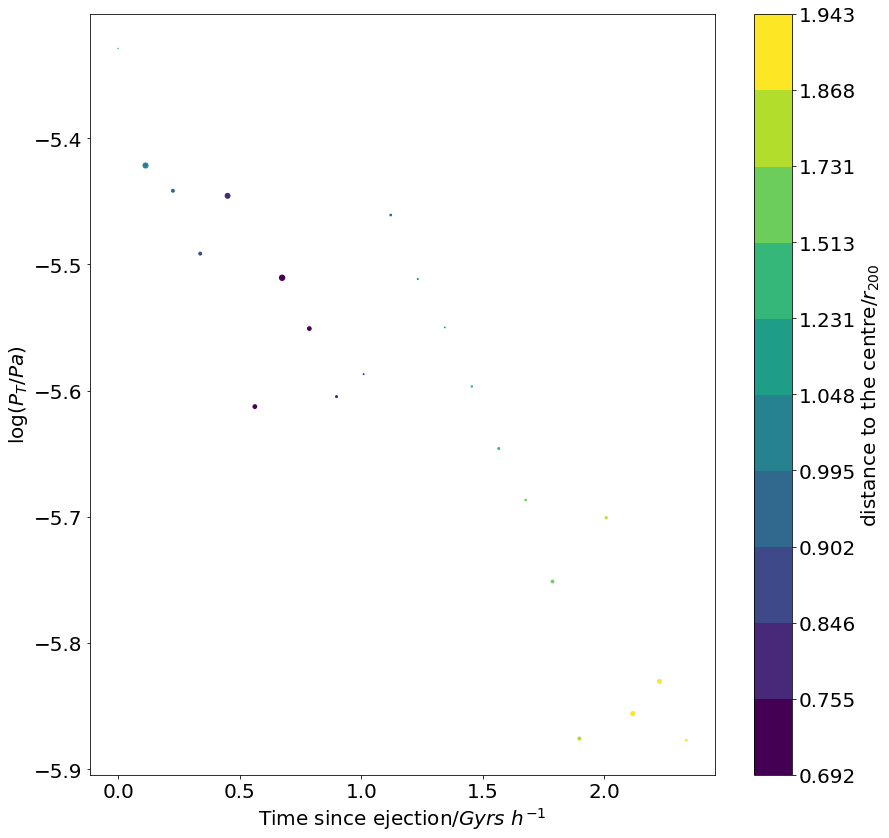

In [29]:
pl.figure(figsize=(14,14))

pl.scatter(tzu, np.log10(RestForce), s=Gas/5e5, c=dist, norm=norm)

# pl.scatter(tzu, np.log10(RPS), c=dist, norm=norm)

# pl.arrow(tz1, -100., 0., 200, color='black', ls=':')
# pl.arrow(tz2, -100., 0., 200, color='black', ls=':')

# pl.arrow(tmerger, -100., 0., 200, color='red', ls=':')

bar = pl.colorbar(label='distance to the centre/$r_{200}$')
bar.set_ticks(papels)

# pl.ylabel('log(Ram Pressure/Pa)')
pl.ylabel('$\log(P_{T}/Pa)$')
pl.xlabel('Time since ejection/$Gyrs\,\,h^{-1}$')

print(z1, z2)

In [30]:
# pl.figure(figsize=(14,14))

# idd = np.where(dist<=3)
# RPS, SFR, gasMass, starMass, Gas, dist, RestForce = RPS[idd], SFR[idd], gasMass[idd], starMass[idd], Gas[idd], dist[idd], RestForce[idd]

# lRPS, lSFR = np.log10(RPS/RestForce), np.log10(SFR)
# pl.scatter(lRPS, lSFR, s=Gas/5e5, c=dist, norm=norm)

# inan = np.where((np.isnan(lRPS)==False) & (np.isnan(lSFR)==False) &(np.isinf(lRPS)==False) & (np.isinf(lSFR)==False))

# print(sp.pearsonr(lRPS[inan], lSFR[inan]))

# bar = pl.colorbar(label='distance to the centre/$r_{200}$')
# bar.set_ticks(papels)

# pl.ylabel('$\log($SFR$/(M_{\odot}\,\,yr^{-1}))$')
# pl.xlabel('log(Ram Pressure/$P_T$)')

In [31]:
# pl.figure(figsize=(14,14))

# lsSFR = np.log10(SFR/starMass)
# pl.scatter(lRPS, lsSFR, s=Gas/5e5, c=dist, norm=norm)

# inan = np.where((np.isnan(lRPS)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lRPS)==False) & (np.isinf(lsSFR)==False))

# print(sp.pearsonr(lRPS[inan], lsSFR[inan]))


# bar = pl.colorbar(label='distance to the centre/$r_{200}$')
# bar.set_ticks(papels)

# pl.ylabel('$\log($sSFR$/yr^{-1})$')
# pl.xlabel('log(Ram Pressure/$P_T$)')

In [32]:
RPS, z, SFR, dist, RestForce, Gas, z1, z2, gasMass, starMass = getSFRs(4474, 4469)

it = np.where(RPS>0.)
RPS, z, SFR, dist, Gas, RestForce, gasMass, starMass = RPS[it], z[it], SFR[it], dist[it], Gas[it], RestForce[it], gasMass[it], starMass[it]

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in less_equal
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:155: RuntimeWarning: invalid value encountered in less_equal


In [33]:
tzu = Cosmo.lookback_time(z).value

idd = np.where(dist<=2)
RPS, SFR, gasMass, starMass, Gas, dist, RestForce, tzu = RPS[idd], SFR[idd], gasMass[idd], starMass[idd], Gas[idd], dist[idd], RestForce[idd], tzu[idd]


tz1 = Cosmo.lookback_time(z1).value
tz2 = Cosmo.lookback_time(z2).value

vaper = np.linspace(0, 100, 11)
papels = np.percentile(dist, vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)


0.3634722484955717 0.4410948805168442


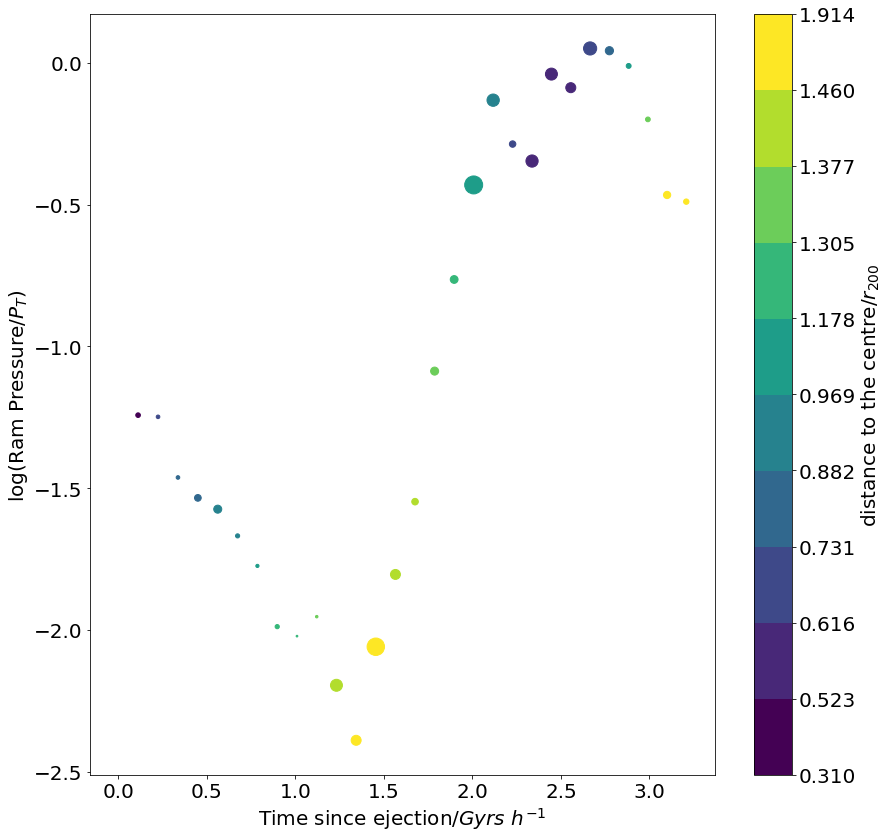

In [34]:
pl.figure(figsize=(14,14))

pl.scatter(tzu, np.log10(RPS/RestForce), s=Gas/5e5, c=dist, norm=norm)

# pl.scatter(tzu, np.log10(RPS), c=dist, norm=norm)

# pl.arrow(tz1, -100., 0., 200, color='black', ls=':')
# pl.arrow(tz2, -100., 0., 200, color='black', ls=':')

bar = pl.colorbar(label='distance to the centre/$r_{200}$')
bar.set_ticks(papels)

# pl.ylabel('log(Ram Pressure/Pa)')
pl.ylabel('$\log($Ram Pressure$/P_{T})$')
pl.xlabel('Time since ejection/$Gyrs\,\,h^{-1}$')

print(z1, z2)

0.3634722484955717 0.4410948805168442


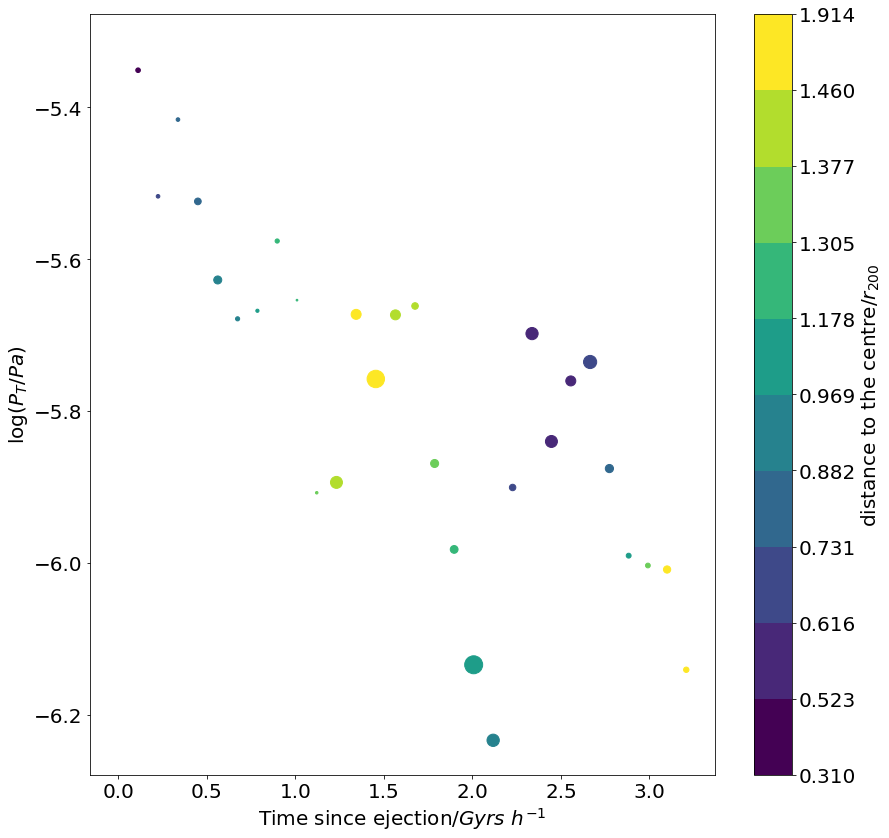

In [35]:
pl.figure(figsize=(14,14))

pl.scatter(tzu, np.log10(RestForce), s=Gas/5e5, c=dist, norm=norm)

# pl.scatter(tzu, np.log10(RPS), c=dist, norm=norm)

# pl.arrow(tz1, -100., 0., 200, color='black', ls=':')
# pl.arrow(tz2, -100., 0., 200, color='black', ls=':')

# pl.arrow(tmerger, -100., 0., 200, color='red', ls=':')

bar = pl.colorbar(label='distance to the centre/$r_{200}$')
bar.set_ticks(papels)

# pl.ylabel('log(Ram Pressure/Pa)')
pl.ylabel('$\log(P_{T}/Pa)$')
pl.xlabel('Time since ejection/$Gyrs\,\,h^{-1}$')

print(z1, z2)

In [36]:
# pl.figure(figsize=(14,14))

# idd = np.where(dist<=3)
# RPS, SFR, gasMass, starMass, Gas, dist, RestForce = RPS[idd], SFR[idd], gasMass[idd], starMass[idd], Gas[idd], dist[idd], RestForce[idd]


# lRPS, lSFR = np.log10(RPS/RestForce), np.log10(SFR)
# pl.scatter(lRPS, lSFR, s=Gas/5e5, c=dist, norm=norm)

# inan = np.where((np.isnan(lRPS)==False) & (np.isnan(lSFR)==False) &(np.isinf(lRPS)==False) & (np.isinf(lSFR)==False))

# print(sp.pearsonr(lRPS[inan], lSFR[inan]))

# bar = pl.colorbar(label='distance to the centre/$r_{200}$')
# bar.set_ticks(papels)

# pl.ylabel('$\log($SFR$/(M_{\odot}\,\,yr^{-1}))$')
# pl.xlabel('log(Ram Pressure/$P_T$)')

In [37]:
# pl.figure(figsize=(14,14))

# lsSFR = np.log10(SFR/starMass)
# pl.scatter(lRPS, lsSFR, s=Gas/5e5, c=dist, norm=norm)

# inan = np.where((np.isnan(lRPS)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lRPS)==False) & (np.isinf(lsSFR)==False))

# print(sp.pearsonr(lRPS[inan], lsSFR[inan]))


# bar = pl.colorbar(label='distance to the centre/$r_{200}$')
# bar.set_ticks(papels)

# pl.ylabel('$\log($sSFR$/yr^{-1})$')
# pl.xlabel('log(Ram Pressure/$P_T$)')

In [38]:
RPS, z, SFR, dist, RestForce, Gas, z1, z2, gasMass, starMass = getSFRs(4338, 4337)

it = np.where(RPS>0.)
RPS, z, SFR, dist, Gas, RestForce, gasMass, starMass = RPS[it], z[it], SFR[it], dist[it], Gas[it], RestForce[it], gasMass[it], starMass[it]

In [39]:
tzu = Cosmo.lookback_time(z).value

idd = np.where(dist<=2)
RPS, SFR, gasMass, starMass, Gas, dist, RestForce, tzu = RPS[idd], SFR[idd], gasMass[idd], starMass[idd], Gas[idd], dist[idd], RestForce[idd], tzu[idd]


tz1 = Cosmo.lookback_time(z1).value
tz2 = Cosmo.lookback_time(z2).value

vaper = np.linspace(0, 100, 11)
papels = np.percentile(dist, vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)


0.24339225775468964 0.38219559019532867


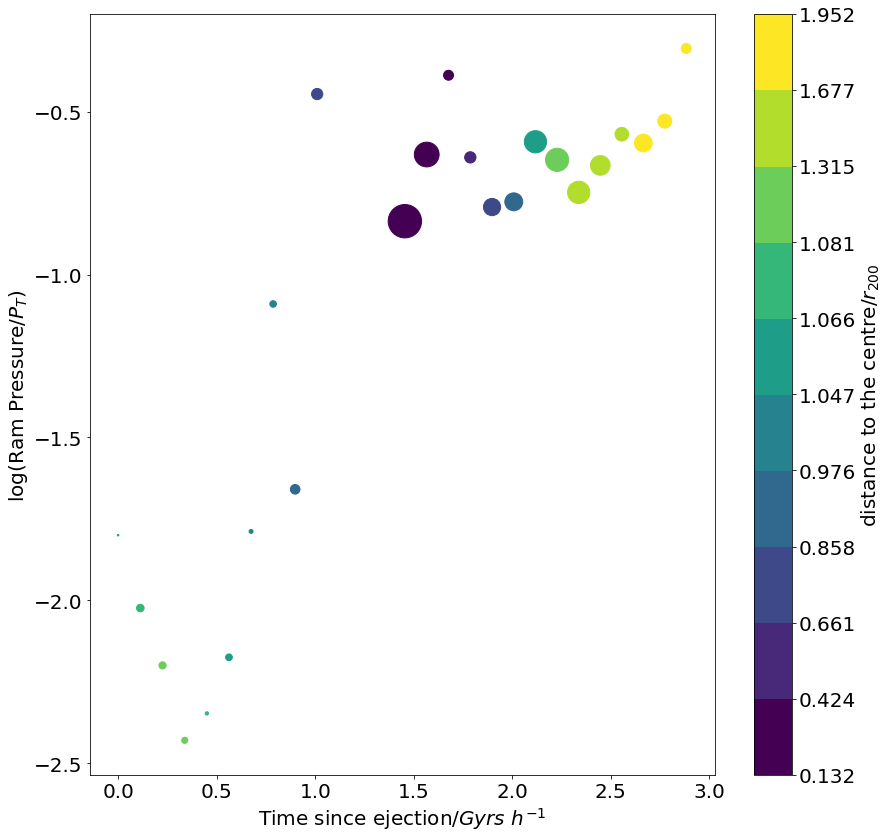

In [40]:
pl.figure(figsize=(14,14))

pl.scatter(tzu, np.log10(RPS/RestForce), s=Gas/5e5, c=dist, norm=norm)

# pl.scatter(tzu, np.log10(RPS), c=dist, norm=norm)

# pl.arrow(tz1, -100., 0., 200, color='black', ls=':')
# pl.arrow(tz2, -100., 0., 200, color='black', ls=':')

bar = pl.colorbar(label='distance to the centre/$r_{200}$')
bar.set_ticks(papels)

# pl.ylabel('log(Ram Pressure/Pa)')
pl.ylabel('$\log($Ram Pressure$/P_{T})$')
pl.xlabel('Time since ejection/$Gyrs\,\,h^{-1}$')

print(z1, z2)

0.24339225775468964 0.38219559019532867


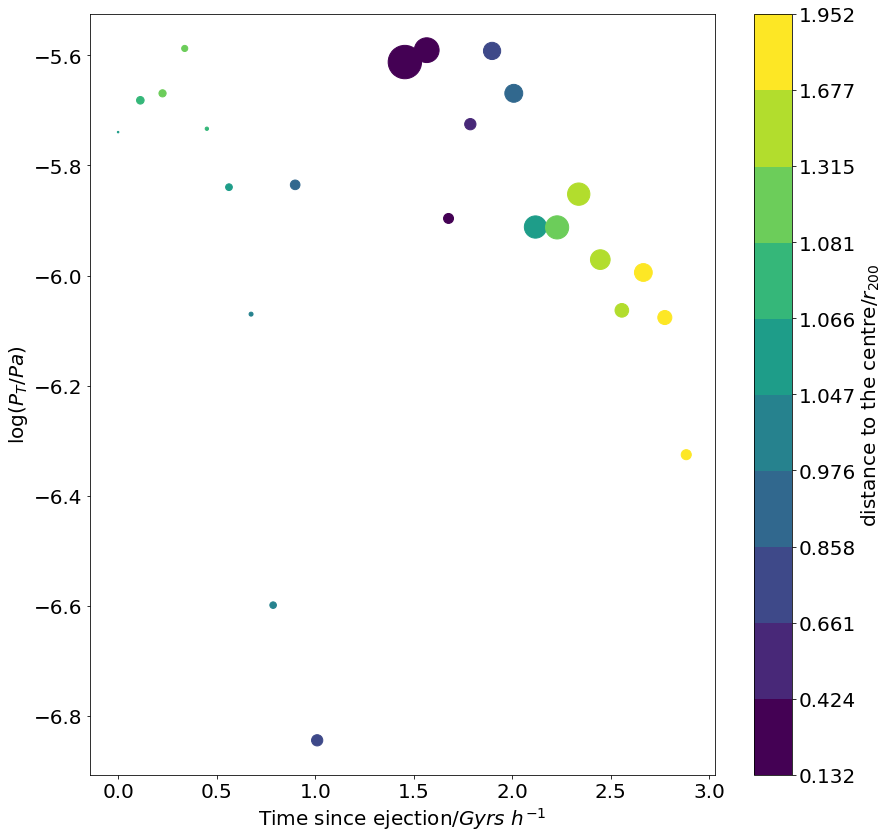

In [41]:
pl.figure(figsize=(14,14))

pl.scatter(tzu, np.log10(RestForce), s=Gas/5e5, c=dist, norm=norm)

# pl.scatter(tzu, np.log10(RPS), c=dist, norm=norm)

# pl.arrow(tz1, -100., 0., 200, color='black', ls=':')
# pl.arrow(tz2, -100., 0., 200, color='black', ls=':')

# pl.arrow(tmerger, -100., 0., 200, color='red', ls=':')

bar = pl.colorbar(label='distance to the centre/$r_{200}$')
bar.set_ticks(papels)

# pl.ylabel('log(Ram Pressure/Pa)')
pl.ylabel('$\log(P_{T}/Pa)$')
pl.xlabel('Time since ejection/$Gyrs\,\,h^{-1}$')

print(z1, z2)

In [42]:
# pl.figure(figsize=(14,14))

# idd = np.where(dist<=3)
# RPS, SFR, gasMass, starMass, Gas, dist, RestForce = RPS[idd], SFR[idd], gasMass[idd], starMass[idd], Gas[idd], dist[idd], RestForce[idd]

# lRPS, lSFR = np.log10(RPS/RestForce), np.log10(SFR)
# pl.scatter(lRPS, lSFR, s=Gas/5e5, c=dist, norm=norm)

# inan = np.where((np.isnan(lRPS)==False) & (np.isnan(lSFR)==False) &(np.isinf(lRPS)==False) & (np.isinf(lSFR)==False))

# print(sp.pearsonr(lRPS[inan], lSFR[inan]))

# bar = pl.colorbar(label='distance to the centre/$r_{200}$')
# bar.set_ticks(papels)

# pl.ylabel('$\log($SFR$/(M_{\odot}\,\,yr^{-1}))$')
# pl.xlabel('log(Ram Pressure/$P_T$)')

In [43]:
# pl.figure(figsize=(14,14))

# lsSFR = np.log10(SFR/starMass)
# pl.scatter(lRPS, lsSFR, s=Gas/5e5, c=dist, norm=norm)

# inan = np.where((np.isnan(lRPS)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lRPS)==False) & (np.isinf(lsSFR)==False))

# print(sp.pearsonr(lRPS[inan], lsSFR[inan]))


# bar = pl.colorbar(label='distance to the centre/$r_{200}$')
# bar.set_ticks(papels)

# pl.ylabel('$\log($sSFR$/yr^{-1})$')
# pl.xlabel('log(Ram Pressure/$P_T$)')

In [44]:
RPS, z, SFR, dist, RestForce, Gas, z1, z2, gasMass, starMass = getSFRs(4339, 4337)

it = np.where(RPS>0.)
RPS, z, SFR, dist, Gas, RestForce, gasMass, starMass = RPS[it], z[it], SFR[it], dist[it], Gas[it], RestForce[it], gasMass[it], starMass[it]

In [45]:

tzu = Cosmo.lookback_time(z).value

idd = np.where(dist<=2)
RPS, SFR, gasMass, starMass, Gas, dist, RestForce, tzu = RPS[idd], SFR[idd], gasMass[idd], starMass[idd], Gas[idd], dist[idd], RestForce[idd], tzu[idd]


tz1 = Cosmo.lookback_time(z1).value
tz2 = Cosmo.lookback_time(z2).value

vaper = np.linspace(0, 100, 11)
papels = np.percentile(dist, vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)


0.6222120052452746 0.7585015073982897


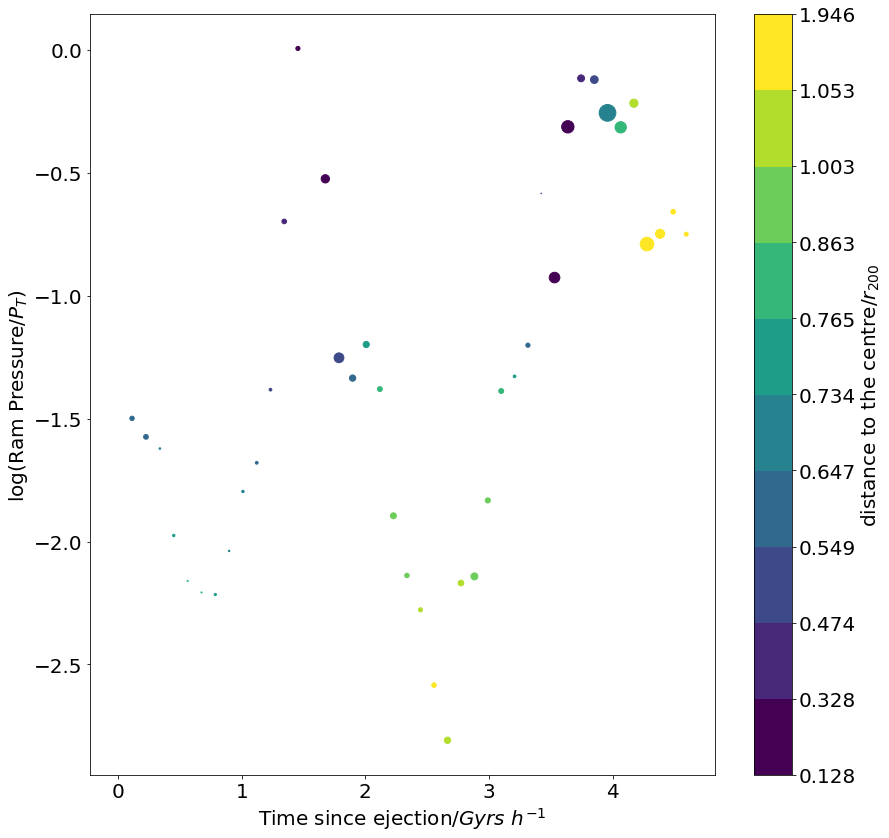

In [46]:
pl.figure(figsize=(14,14))

pl.scatter(tzu, np.log10(RPS/RestForce), s=Gas/5e5, c=dist, norm=norm)

# pl.scatter(tzu, np.log10(RPS), c=dist, norm=norm)

# pl.arrow(tz1, -100., 0., 200, color='black', ls=':')
# pl.arrow(tz2, -100., 0., 200, color='black', ls=':')

bar = pl.colorbar(label='distance to the centre/$r_{200}$')
bar.set_ticks(papels)

# pl.ylabel('log(Ram Pressure/Pa)')
pl.ylabel('$\log($Ram Pressure$/P_{T})$')
pl.xlabel('Time since ejection/$Gyrs\,\,h^{-1}$')

print(z1, z2)

0.6222120052452746 0.7585015073982897


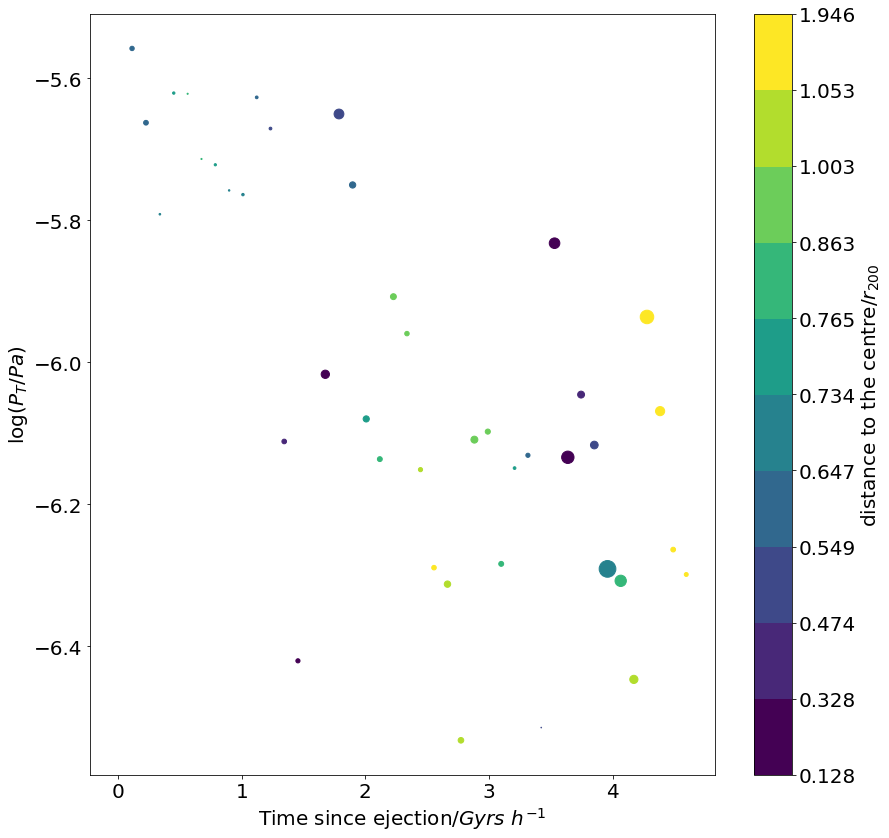

In [47]:
pl.figure(figsize=(14,14))

pl.scatter(tzu, np.log10(RestForce), s=Gas/5e5, c=dist, norm=norm)

# pl.scatter(tzu, np.log10(RPS), c=dist, norm=norm)

# pl.arrow(tz1, -100., 0., 200, color='black', ls=':')
# pl.arrow(tz2, -100., 0., 200, color='black', ls=':')

# pl.arrow(tmerger, -100., 0., 200, color='red', ls=':')

bar = pl.colorbar(label='distance to the centre/$r_{200}$')
bar.set_ticks(papels)

# pl.ylabel('log(Ram Pressure/Pa)')
pl.ylabel('$\log(P_{T}/Pa)$')
pl.xlabel('Time since ejection/$Gyrs\,\,h^{-1}$')

print(z1, z2)

In [48]:
# pl.figure(figsize=(14,14))

# idd = np.where(dist<=3)
# RPS, SFR, gasMass, starMass, Gas, dist, RestForce = RPS[idd], SFR[idd], gasMass[idd], starMass[idd], Gas[idd], dist[idd], RestForce[idd]

# lRPS, lSFR = np.log10(RPS/RestForce), np.log10(SFR)
# pl.scatter(lRPS, lSFR, s=Gas/5e5, c=dist, norm=norm)

# inan = np.where((np.isnan(lRPS)==False) & (np.isnan(lSFR)==False) &(np.isinf(lRPS)==False) & (np.isinf(lSFR)==False))

# print(sp.pearsonr(lRPS[inan], lSFR[inan]))

# bar = pl.colorbar(label='distance to the centre/$r_{200}$')
# bar.set_ticks(papels)

# pl.ylabel('$\log($SFR$/(M_{\odot}\,\,yr^{-1}))$')
# pl.xlabel('log(Ram Pressure/$P_T$)')

In [49]:
# pl.figure(figsize=(14,14))

# lsSFR = np.log10(SFR/starMass)
# pl.scatter(lRPS, lsSFR, s=Gas/5e5, c=dist, norm=norm)

# inan = np.where((np.isnan(lRPS)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lRPS)==False) & (np.isinf(lsSFR)==False))

# print(sp.pearsonr(lRPS[inan], lsSFR[inan]))


# bar = pl.colorbar(label='distance to the centre/$r_{200}$')
# bar.set_ticks(papels)

# pl.ylabel('$\log($sSFR$/yr^{-1})$')
# pl.xlabel('log(Ram Pressure/$P_T$)')

In [50]:
RPS, z, SFR, dist, RestForce, Gas, z1, z2, gasMass, starMass = getSFRs(4341, 4337)

it = np.where(RPS>0.)
RPS, z, SFR, dist, Gas, RestForce, gasMass, starMass = RPS[it], z[it], SFR[it], dist[it], Gas[it], RestForce[it], gasMass[it], starMass[it]

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in less_equal
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:155: RuntimeWarning: invalid value encountered in less_equal


In [51]:
tzu = Cosmo.lookback_time(z).value

idd = np.where(dist<=2)
RPS, SFR, gasMass, starMass, Gas, dist, RestForce, tzu = RPS[idd], SFR[idd], gasMass[idd], starMass[idd], Gas[idd], dist[idd], RestForce[idd], tzu[idd]


tz1 = Cosmo.lookback_time(z1).value
tz2 = Cosmo.lookback_time(z2).value

vaper = np.linspace(0, 100, 11)
papels = np.percentile(dist, vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)


0.2594730228456261 0.3634722484955717


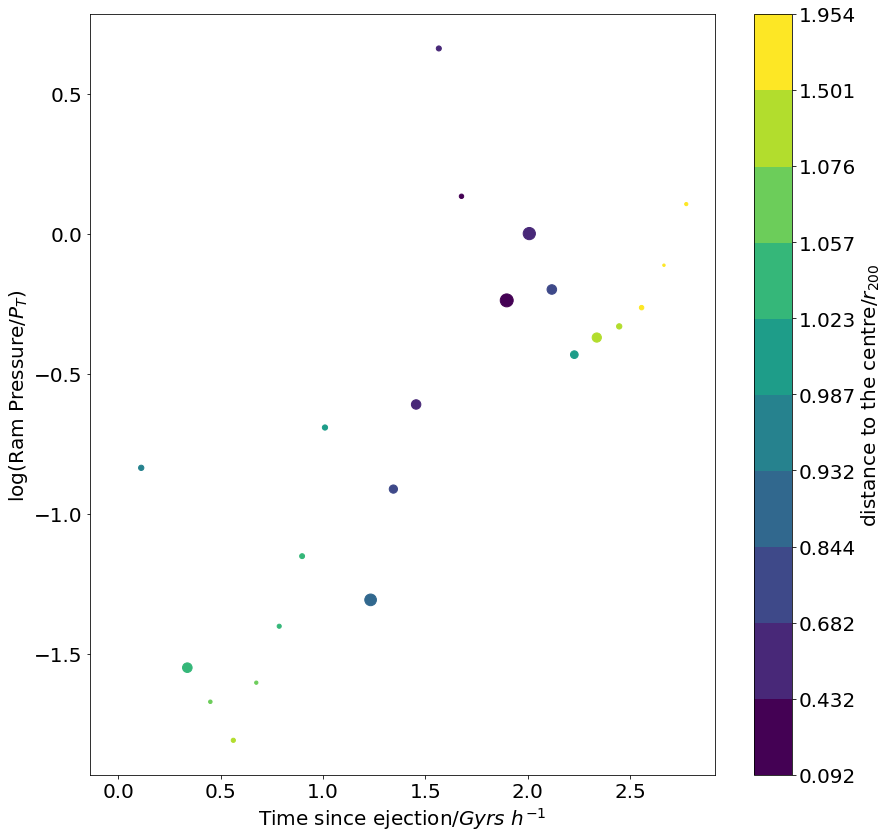

In [52]:
pl.figure(figsize=(14,14))

pl.scatter(tzu, np.log10(RPS/RestForce), s=Gas/5e5, c=dist, norm=norm)

# pl.scatter(tzu, np.log10(RPS), c=dist, norm=norm)

# pl.arrow(tz1, -100., 0., 200, color='black', ls=':')
# pl.arrow(tz2, -100., 0., 200, color='black', ls=':')

bar = pl.colorbar(label='distance to the centre/$r_{200}$')
bar.set_ticks(papels)

# pl.ylabel('log(Ram Pressure/Pa)')
pl.ylabel('$\log($Ram Pressure$/P_{T})$')
pl.xlabel('Time since ejection/$Gyrs\,\,h^{-1}$')

print(z1, z2)

0.2594730228456261 0.3634722484955717


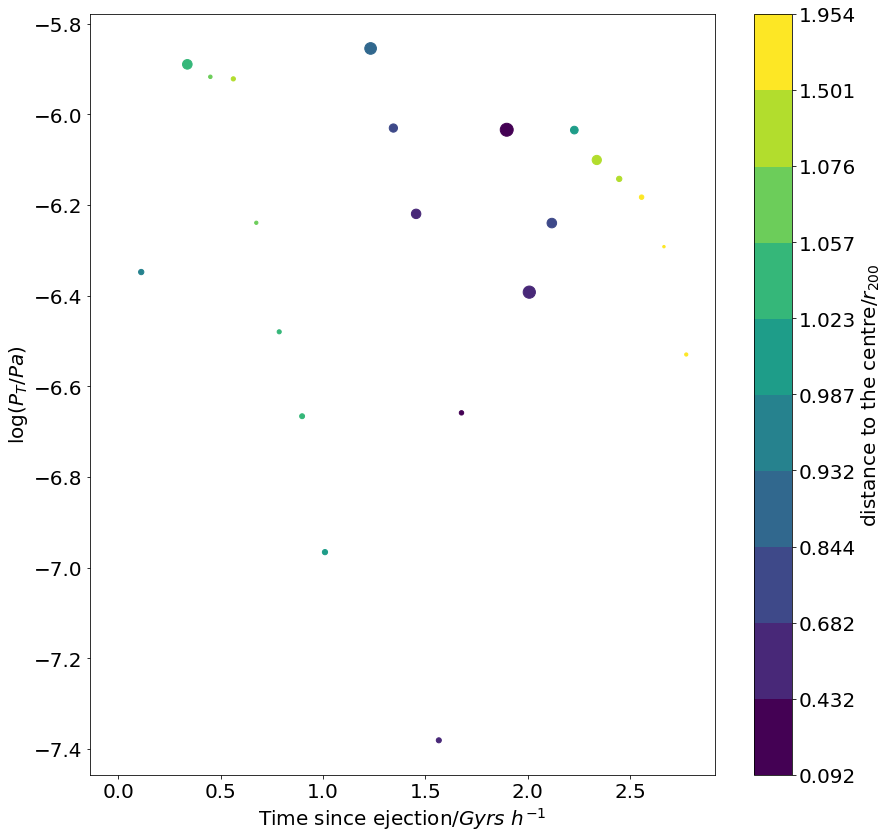

In [53]:
pl.figure(figsize=(14,14))

pl.scatter(tzu, np.log10(RestForce), s=Gas/5e5, c=dist, norm=norm)

# pl.scatter(tzu, np.log10(RPS), c=dist, norm=norm)

# pl.arrow(tz1, -100., 0., 200, color='black', ls=':')
# pl.arrow(tz2, -100., 0., 200, color='black', ls=':')

# pl.arrow(tmerger, -100., 0., 200, color='red', ls=':')

bar = pl.colorbar(label='distance to the centre/$r_{200}$')
bar.set_ticks(papels)

# pl.ylabel('log(Ram Pressure/Pa)')
pl.ylabel('$\log(P_{T}/Pa)$')
pl.xlabel('Time since ejection/$Gyrs\,\,h^{-1}$')

print(z1, z2)

In [54]:
# pl.figure(figsize=(14,14))

# idd = np.where(dist<=3)
# RPS, SFR, gasMass, starMass, Gas, dist, RestForce = RPS[idd], SFR[idd], gasMass[idd], starMass[idd], Gas[idd], dist[idd], RestForce[idd]

# lRPS, lSFR = np.log10(RPS/RestForce), np.log10(SFR)
# pl.scatter(lRPS, lSFR, s=Gas/5e5, c=dist, norm=norm)

# inan = np.where((np.isnan(lRPS)==False) & (np.isnan(lSFR)==False) &(np.isinf(lRPS)==False) & (np.isinf(lSFR)==False))

# print(sp.pearsonr(lRPS[inan], lSFR[inan]))

# bar = pl.colorbar(label='distance to the centre/$r_{200}$')
# bar.set_ticks(papels)

# pl.ylabel('$\log($SFR$/(M_{\odot}\,\,yr^{-1}))$')
# pl.xlabel('log(Ram Pressure/$P_T$)')

In [55]:
# pl.figure(figsize=(14,14))

# lsSFR = np.log10(SFR/starMass)
# pl.scatter(lRPS, lsSFR, s=Gas/5e5, c=dist, norm=norm)

# inan = np.where((np.isnan(lRPS)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lRPS)==False) & (np.isinf(lsSFR)==False))

# print(sp.pearsonr(lRPS[inan], lsSFR[inan]))


# bar = pl.colorbar(label='distance to the centre/$r_{200}$')
# bar.set_ticks(papels)

# pl.ylabel('$\log($sSFR$/yr^{-1})$')
# pl.xlabel('log(Ram Pressure/$P_T$)')

In [56]:
RPS, z, SFR, dist, RestForce, Gas, z1, z2, gasMass, starMass = getSFRs(4343, 4337)

it = np.where(RPS>0.)
RPS, z, SFR, dist, Gas, RestForce, gasMass, starMass = RPS[it], z[it], SFR[it], dist[it], Gas[it], RestForce[it], gasMass[it], starMass[it]

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in less_equal
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:155: RuntimeWarning: invalid value encountered in less_equal


In [57]:
tzu = Cosmo.lookback_time(z).value

idd = np.where(dist<=2)
RPS, SFR, gasMass, starMass, Gas, dist, RestForce, tzu = RPS[idd], SFR[idd], gasMass[idd], starMass[idd], Gas[idd], dist[idd], RestForce[idd], tzu[idd]


tz1 = Cosmo.lookback_time(z1).value
tz2 = Cosmo.lookback_time(z2).value

vaper = np.linspace(0, 100, 11)
papels = np.percentile(dist, vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)


0.7295044617356536 0.9193183477038258


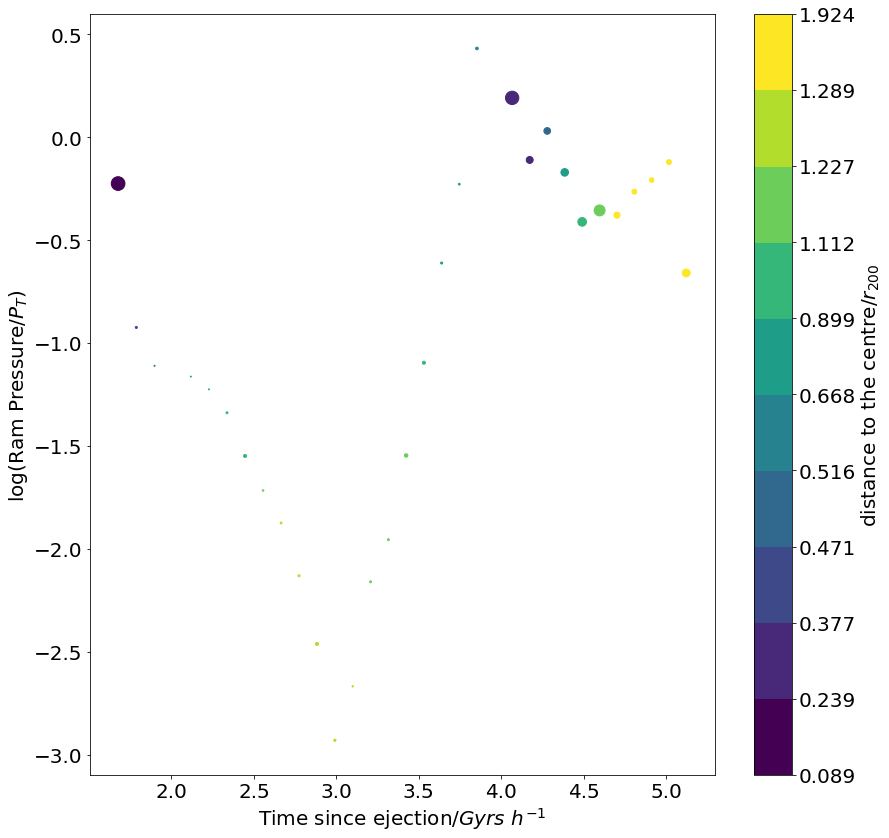

In [58]:
pl.figure(figsize=(14,14))

pl.scatter(tzu, np.log10(RPS/RestForce), s=Gas/5e5, c=dist, norm=norm)

# pl.scatter(tzu, np.log10(RPS), c=dist, norm=norm)

# pl.arrow(tz1, -100., 0., 200, color='black', ls=':')
# pl.arrow(tz2, -100., 0., 200, color='black', ls=':')

bar = pl.colorbar(label='distance to the centre/$r_{200}$')
bar.set_ticks(papels)

# pl.ylabel('log(Ram Pressure/Pa)')
pl.ylabel('$\log($Ram Pressure$/P_{T})$')
pl.xlabel('Time since ejection/$Gyrs\,\,h^{-1}$')

print(z1, z2)

0.7295044617356536 0.9193183477038258


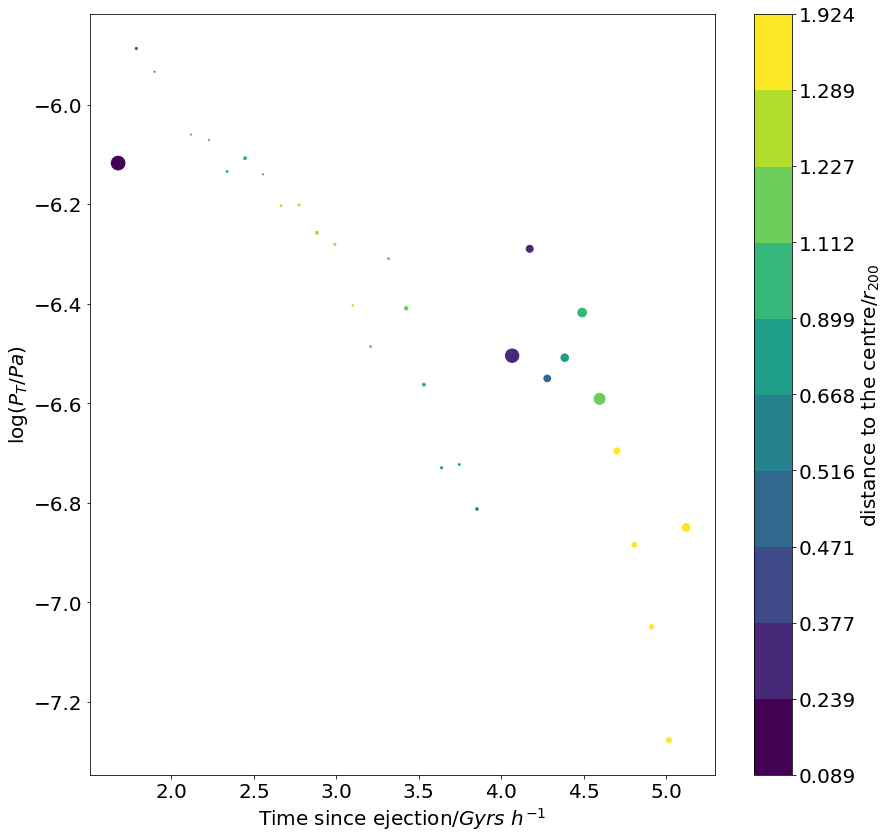

In [59]:
pl.figure(figsize=(14,14))

pl.scatter(tzu, np.log10(RestForce), s=Gas/5e5, c=dist, norm=norm)

# pl.scatter(tzu, np.log10(RPS), c=dist, norm=norm)

# pl.arrow(tz1, -100., 0., 200, color='black', ls=':')
# pl.arrow(tz2, -100., 0., 200, color='black', ls=':')

# pl.arrow(tmerger, -100., 0., 200, color='red', ls=':')

bar = pl.colorbar(label='distance to the centre/$r_{200}$')
bar.set_ticks(papels)

# pl.ylabel('log(Ram Pressure/Pa)')
pl.ylabel('$\log(P_{T}/Pa)$')
pl.xlabel('Time since ejection/$Gyrs\,\,h^{-1}$')

print(z1, z2)

In [60]:
# pl.figure(figsize=(14,14))

# idd = np.where(dist<=3)
# RPS, SFR, gasMass, starMass, Gas, dist, RestForce = RPS[idd], SFR[idd], gasMass[idd], starMass[idd], Gas[idd], dist[idd], RestForce[idd]

# lRPS, lSFR = np.log10(RPS/RestForce), np.log10(SFR)
# pl.scatter(lRPS, lSFR, s=Gas/5e5, c=dist, norm=norm)

# inan = np.where((np.isnan(lRPS)==False) & (np.isnan(lSFR)==False) &(np.isinf(lRPS)==False) & (np.isinf(lSFR)==False))

# print(sp.pearsonr(lRPS[inan], lSFR[inan]))

# bar = pl.colorbar(label='distance to the centre/$r_{200}$')
# bar.set_ticks(papels)

# pl.ylabel('$\log($SFR$/(M_{\odot}\,\,yr^{-1}))$')
# pl.xlabel('log(Ram Pressure/$P_T$)')

In [61]:
# pl.figure(figsize=(14,14))

# lsSFR = np.log10(SFR/starMass)
# pl.scatter(lRPS, lsSFR, s=Gas/5e5, c=dist, norm=norm)

# inan = np.where((np.isnan(lRPS)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lRPS)==False) & (np.isinf(lsSFR)==False))

# print(sp.pearsonr(lRPS[inan], lsSFR[inan]))


# bar = pl.colorbar(label='distance to the centre/$r_{200}$')
# bar.set_ticks(papels)

# pl.ylabel('$\log($sSFR$/yr^{-1})$')
# pl.xlabel('log(Ram Pressure/$P_T$)')